## Data Mining Project 
### Portugese Student Performance
Nemo Ingendaa (s1063653) and Maikel Jans (s1057498)

## Data Mining Project 
### Portugese Student Performance
Nemo Ingendaa (s1063653) and Maikel Jans (s1057498)

#### Loading data

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

mat = pd.read_csv("Dataset/student-combined.csv", sep=';') # load dataset of the math classes 

mat.columns = ['school','sex','age','address','familySize','parentsStatus','motherEducation','fatherEducation',
        'motherJob','fatherJob','reason','guardian','commuteTime','studyTime','failures','schoolSupport',
        'familySupport','paidClasses','activities','nursery','desireHigherEdu','internet','romantic','familyQuality',
        'freeTime','goOutFriends','workdayAlc','weekendAlc','health','absences','1stPeriod','2ndPeriod','final']

# for i in mat.columns:
#     print(mat[i].value_counts())


#### Preparing data

In [11]:
mat['passed'] = 'None'
mat.loc[(mat.final >= 11) & (mat.final <= 20), 'passed'] = 1
mat.loc[(mat.final >= 0) & (mat.final <= 10), 'passed'] = 0

X = mat.copy(deep=True) # copying mat without changing the original when X is changed

y = X['passed'].ravel()
y = y.astype('int')

X['school'] = [0 if i == 'GP' else 1 for i in X['school']] # GP = 0, MS = 1
X['sex'] = [0 if i == 'M' else 1 for i in X['sex']] # M = 0, F = 1
X['address'] = [0 if i == 'U' else 1 for i in X['address']] # U = 0, R = 1
X['familySize'] = [0 if i == 'LE3' else 1 for i in X['familySize']] # LE3 = 0, GE3 = 1
X['parentsStatus'] = [0 if i == 'T' else 1 for i in X['parentsStatus']] # T = 0, A = 1
X['schoolSupport'] = [0 if i == 'no' else 1 for i in X['schoolSupport']] # no = 0, yes = 1
X['familySupport'] = [0 if i == 'no' else 1 for i in X['familySupport']] # no = 0, yes = 1
X['paidClasses'] = [0 if i == 'no' else 1 for i in X['paidClasses']] # no = 0, yes = 1
X['activities'] = [0 if i == 'no' else 1 for i in X['activities']] # no = 0, yes = 1
X['nursery'] = [0 if i == 'no' else 1 for i in X['nursery']] # no = 0, yes = 1
X['desireHigherEdu'] = [0 if i == 'no' else 1 for i in X['desireHigherEdu']] # no = 0, yes = 1
X['internet'] = [0 if i == 'no' else 1 for i in X['internet']] # no = 0, yes = 1
X['romantic'] = [0 if i == 'no' else 1 for i in X['romantic']] # no = 0, yes = 1

X = pd.get_dummies(X,columns=['motherJob','fatherJob','reason','guardian'])
X.drop(['1stPeriod','2ndPeriod','passed'], axis=1, inplace=True)

X_proc = X.copy(deep=True)
X_proc.drop(['final'], axis=1, inplace=True)
y_proc = np.asarray(y)
attribute_names = X_proc.columns
class_names = ['insufficient', 'sufficient']

X_proc = X_proc.values.tolist() # make X into a list(needed for creating a decision tree)
X_proc = np.asarray(X_proc)

#### Correlation with final grade:

In [4]:
corrToFinal = X.corr()['final']
positiveCorr = corrToFinal[corrToFinal > 0].sort_values()[:-1]
negativeCorr = corrToFinal[corrToFinal < 0].sort_values()[::-1]

print(positiveCorr)
print()
print(negativeCorr)

reason_home           0.003895
guardian_mother       0.009746
familySupport         0.013313
parentsStatus         0.030693
sex                   0.031472
activities            0.033998
nursery               0.039950
fatherJob_health      0.042101
guardian_father       0.042778
motherJob_services    0.045015
familyQuality         0.054461
motherJob_teacher     0.084521
motherJob_health      0.101349
fatherJob_teacher     0.101361
internet              0.107064
reason_reputation     0.121303
fatherEducation       0.159796
studyTime             0.161629
motherEducation       0.201472
desireHigherEdu       0.236578
Name: final, dtype: float64

fatherJob_at_home    -0.021194
fatherJob_other      -0.023825
fatherJob_services   -0.035273
reason_other         -0.043097
absences             -0.045671
paidClasses          -0.049388
familySize           -0.061209
freeTime             -0.064890
motherJob_other      -0.066051
schoolSupport        -0.079346
health               -0.080079
reason_cou

#### Pie chart (insufficient and sufficient)

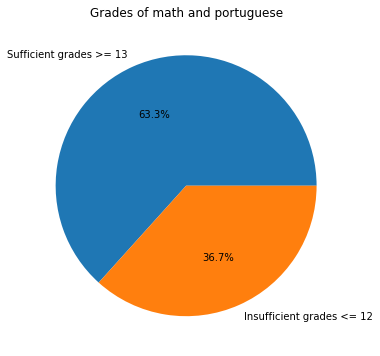

In [5]:
insufficient = X.loc[X['final'] <= 10].count()[0]
sufficient = X.loc[(X['final'] >= 11)].count()[0]

# pieplot
plt.figure(figsize=(10, 6), facecolor='white')
labels = ['Sufficient grades >= 13', 'Insufficient grades <= 12']
plt.pie([sufficient, insufficient], labels=labels, autopct='%1.1f%%', shadow=False)
plt.title('Grades of math and portuguese')
plt.show()
plt.close()

#### Baseline

In [6]:
sufficient = np.count_nonzero(y == 1)
insufficient = np.count_nonzero(y == 0)
print(1-insufficient/sufficient)

0.4205748865355522


#### Cross Validation for decision tree (best max_depth)

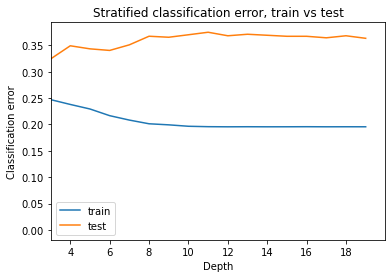

In [38]:
nr_of_splits = 10
max_depth = 20
train_error_list = np.zeros((nr_of_splits,max_depth))
test_error_list = np.zeros((nr_of_splits,max_depth))
for i, (train, test) in enumerate(StratifiedKFold(n_splits=nr_of_splits).split(X_proc,y_proc) ):
    X_train = X_proc[train]
    y_train = y_proc[train]
    X_test = X_proc[test]
    y_test = y_proc[test]
    for j in range (2,max_depth):
        train = []
        test = []
        dtc =  DecisionTreeClassifier(criterion = 'gini', max_depth = j, min_samples_leaf = 10)
        for k in range(10):
            dtc = dtc.fit(X_train, y_train)
            y_train_pred = dtc.predict(X_train)
            y_test_pred = dtc.predict(X_test)
            train_error = 1 - accuracy_score(y_train, y_train_pred)
            test_error = 1 - accuracy_score(y_test, y_test_pred)
            train.append(train_error)
            test.append(test_error)
        train_error_list[i, j] = np.average(train)
        test_error_list[i, j] = np.average(test_error) 

plt.title('Stratified classification error, train vs test')
plt.plot(train_error_list.mean(0), label = "train")
plt.plot(test_error_list.mean(0),label = "test")
plt.xticks(np.arange(0,max_depth,2))
plt.xlim([3,max_depth])
plt.ylabel('Classification error')
plt.xlabel('Depth')
plt.legend()
plt.show()

# Best max_depth = 5

#### Plotting a Decision tree

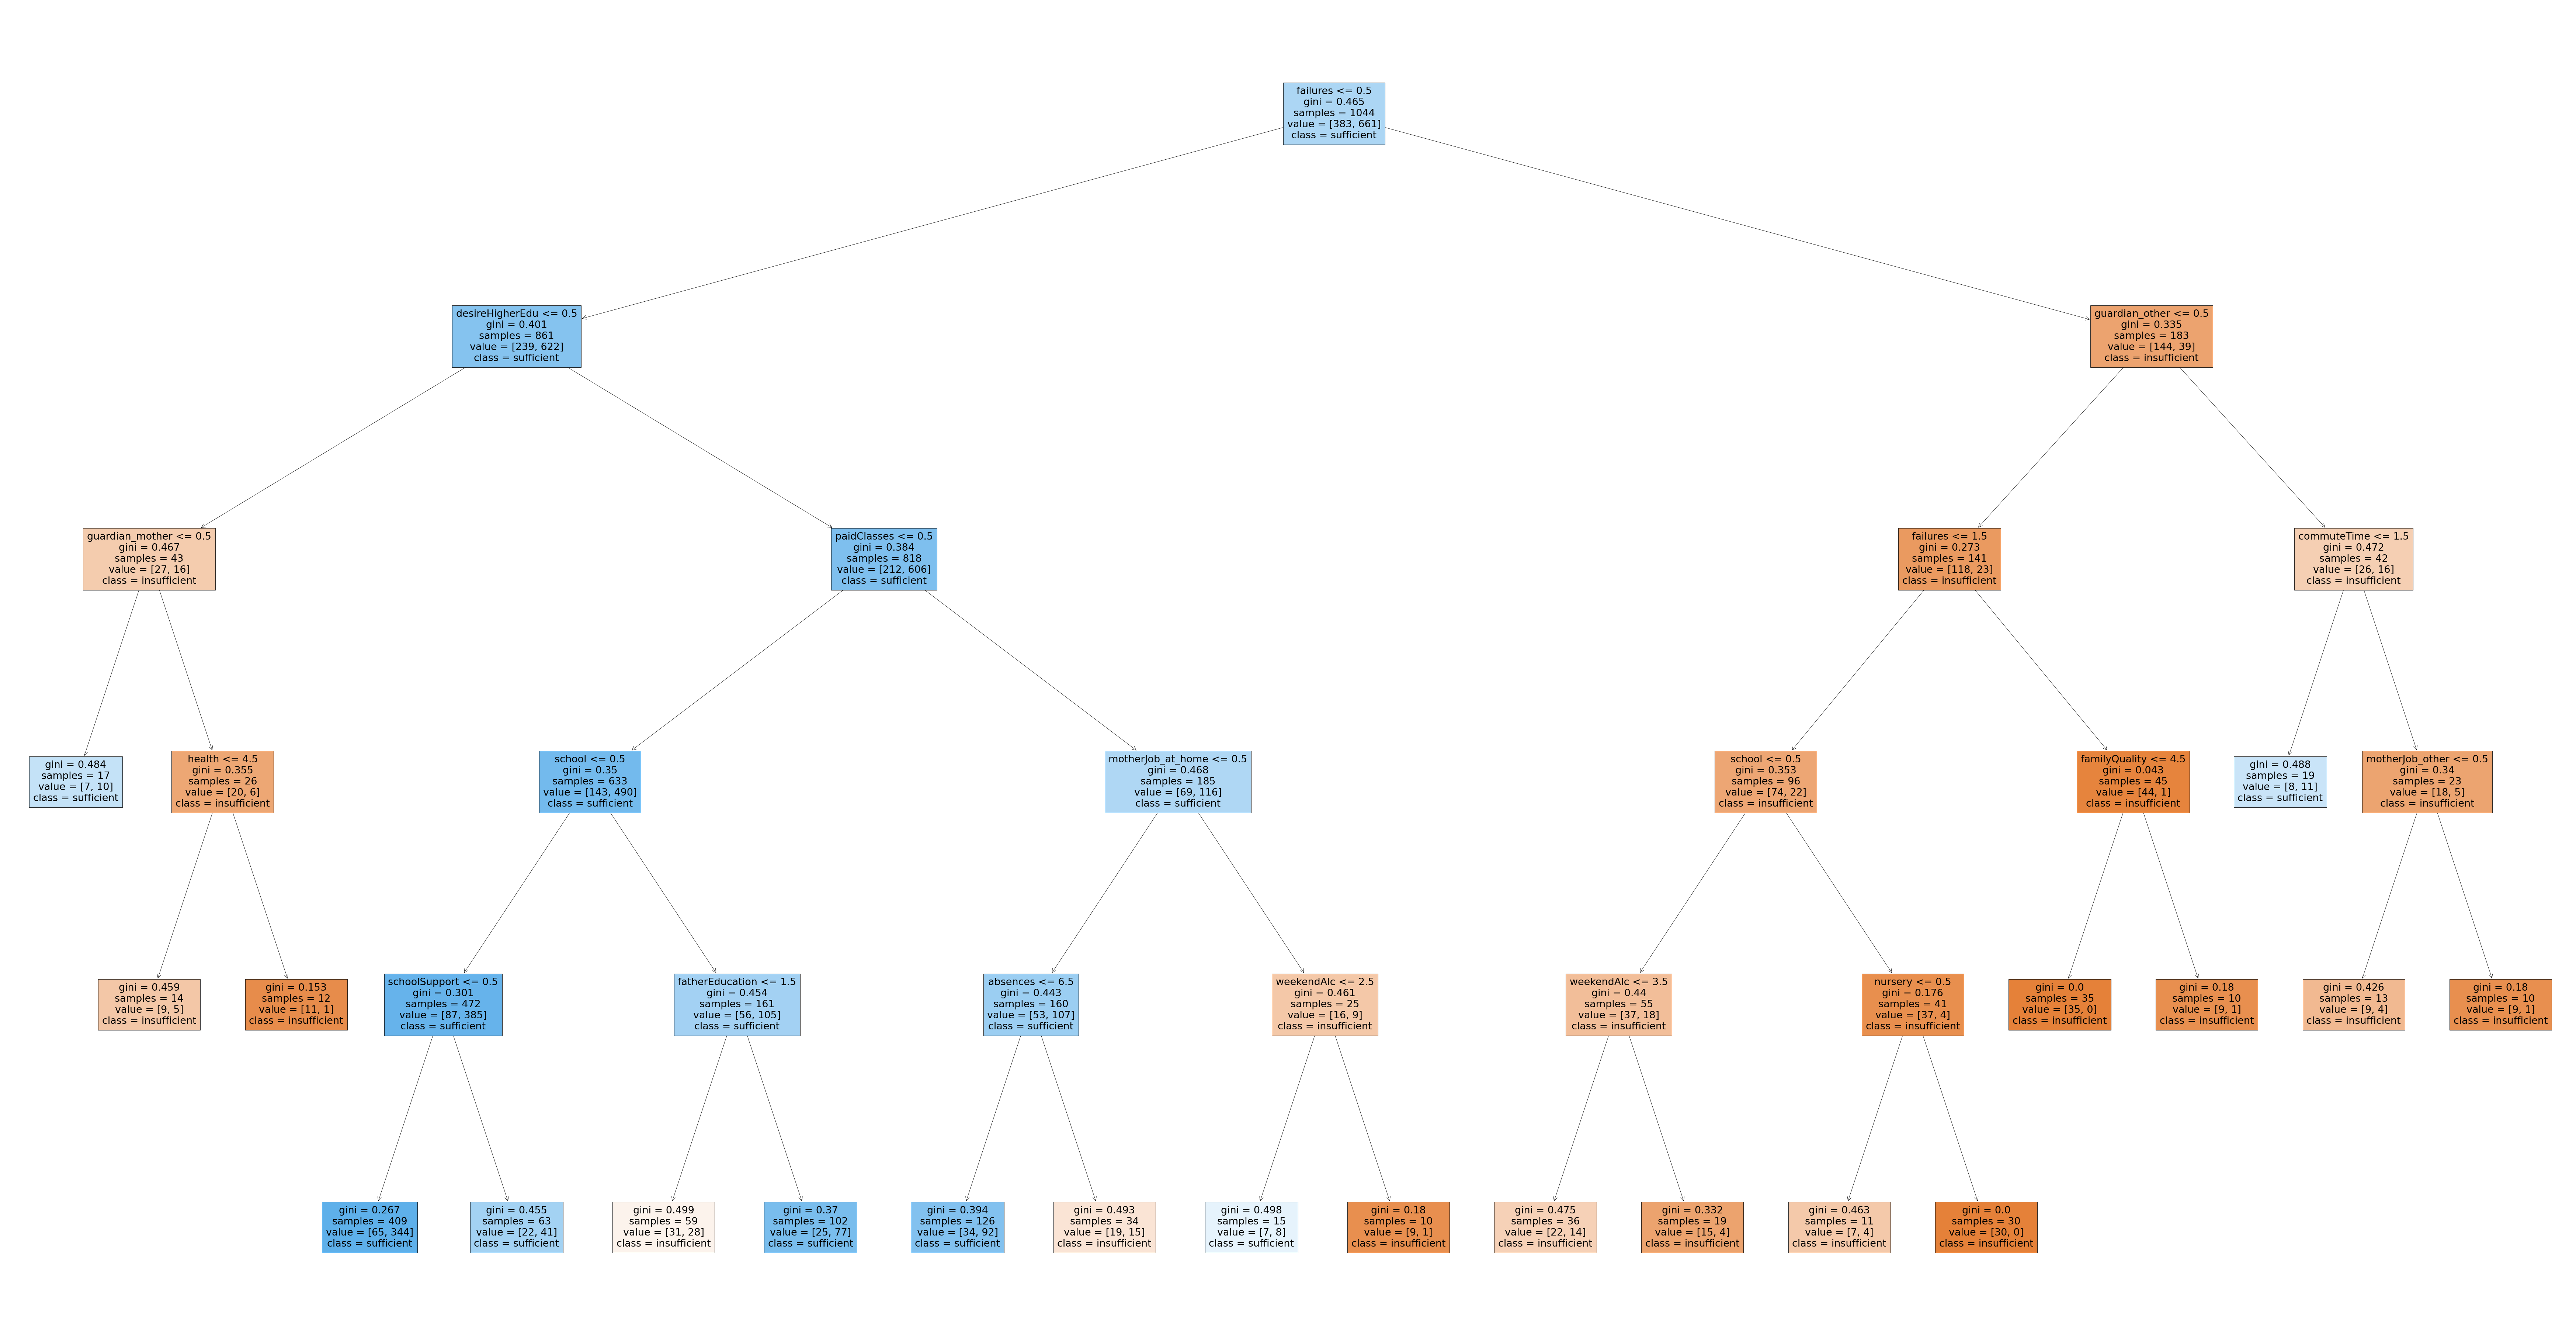

In [39]:
from sklearn.tree import plot_tree
dtc = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10)
dtc = dtc.fit(X_proc, y_proc)
plt.figure(figsize=(150,80), dpi=60, facecolor='white')

plot_tree(dtc, feature_names = attribute_names, class_names = class_names, filled =True)
plt.savefig("decisiontree.pdf")

### Confusion Matrix

##### With k-nearest neighbors

0.33757961783439494


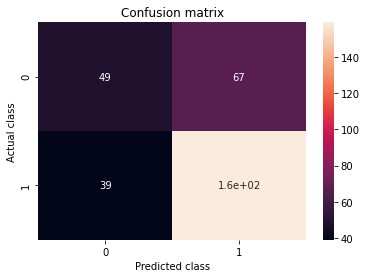

In [9]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_proc, y_proc, test_size=0.3, random_state=1234)
knClass = KNeighborsClassifier(n_neighbors= 5, metric='cosine').fit(X_train,y_train)
y_test_pred = knClass.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
error = 1 - accuracy_test
print(error)
cm = confusion_matrix(y_test,y_test_pred)
df_cm = pd.DataFrame(cm, index = [i for i in np.unique(y)], columns = [i for i in np.unique(y)])
plt.figure()
sn.heatmap(df_cm, annot=True)
plt.title('Confusion matrix')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.show()

##### With Gradient boosting (test size)

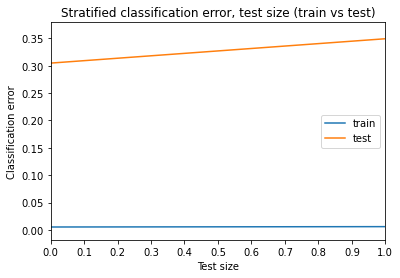

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
nr_of_increments = 10
train_error_list = np.zeros(nr_of_increments)
test_error_list = np.zeros(nr_of_increments)

j = 0.1
index_increments = 0
clf = GradientBoostingClassifier(max_depth=7, max_features=1.0, min_samples_leaf=3, n_estimators=500)
while j <= 0.9:
    X_train, X_test, y_train, y_test = train_test_split(X_proc, y_proc, test_size=j)
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    train_error = 1 - accuracy_score(y_train, y_train_pred)
    test_error = 1 - accuracy_score(y_test, y_test_pred)
    
    train_error_list[index_increments] = train_error
    test_error_list[index_increments] = test_error
    j += 0.1
    index_increments += 1

plt.title('Stratified classification error, test size (train vs test)')
plt.plot(train_error_list, label = "train")
plt.plot(test_error_list,label = "test")
plt.xticks(np.arange(0,nr_of_increments,0.1))
plt.xlim([0,1])
plt.ylabel('Classification error')
plt.xlabel('Test size')
plt.legend()
plt.show()  

##### With Gradient boosting (depth)

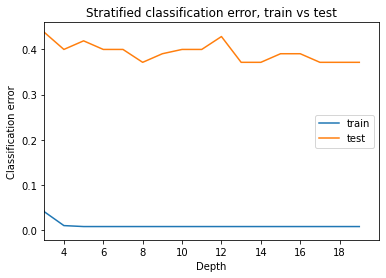

In [ ]:
from sklearn.metrics import accuracy_score

max_depth = 20
train_error_list = np.zeros(max_depth)
test_error_list = np.zeros(max_depth)
X_train, X_test, y_train, y_test = train_test_split(X_proc, y_proc, test_size=0.1)
for j in range (2,max_depth):
    clf = GradientBoostingClassifier(max_depth=j, max_features=1.0, min_samples_leaf=3, n_estimators=500, random_state=1337)
    clf = clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    train_error_list[j] = 1 - accuracy_score(y_train, y_train_pred)
    test_error_list[j] = 1 - accuracy_score(y_test, y_test_pred)

plt.title('Stratified classification error, depth (train vs test)')
plt.plot(train_error_list, label = "train")
plt.plot(test_error_list, label = "test")
plt.xticks(np.arange(0,max_depth,2))
plt.xlim([3,max_depth])
plt.ylabel('Classification error')
plt.xlabel('Depth')
plt.legend()
plt.show()

# Best max_depth = 13

Average error: 0.27714285714285714
Lowest error is: 0.2571428571428571


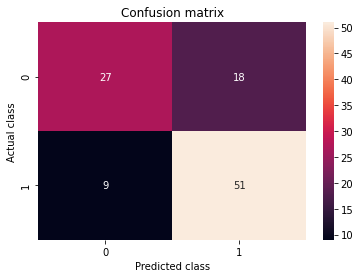

In [ ]:
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_proc, y_proc, test_size=0.1)
clf = GradientBoostingClassifier(max_depth=13, max_features=1.0, min_samples_leaf=3, n_estimators=500)
error_list = []     
df_cm_list = []     
for i in range(10):           
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    error = 1 - accuracy_test
    error_list.append(error)
    cm = confusion_matrix(y_test,y_test_pred)
    df_cm = pd.DataFrame(cm, index = [i for i in np.unique(y)], columns = [i for i in np.unique(y)])
    df_cm_list.append(df_cm)

value = min(error_list)
index = error_list.index(value)
avg = sum(error_list)/len(error_list)
print("Average error: " + str(avg))
print("Lowest error is: " + str(value))
plt.figure()
sn.heatmap(df_cm_list[index], annot=True)
plt.title('Confusion matrix')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.show()